In [1]:
%load_ext autoreload
%autoreload 2

## Imports and flags

In [2]:
from envs.env import *
import pandas as pd
from config import settings
import pickle
from constants import MAB_FEATURE_NAMES

RESTART_data = False # restart prepare training data
negative_sampling_ratio = 10
gamma = 0.25 # (self.gamma * 1 + (1-self.gamma) * actual_reward)
time_split_date = '2024-12-20' # Validation split, if not put None
RESTART = False # restart Curator Network training
RESTART_reward = False

## Open Data

In [3]:
catalog_df = pd.read_parquet("data/whatson_catalog_df.parquet")
historical_data_df = pd.read_pickle("data/historical_data_df.pkl")
with open(settings.aud_model_dir/"rf_model.pkl", "rb") as f:    # load frozen viewership model
    audience_model = pickle.load(f)

In [4]:
historical_data_df

,title,date,content_class_key,channel,duration_min,hour,day,weekday,is_weekend,month,rt_m,tmdb_id,season,processed_title,missing_tmdb_id,catalog_id
22,Cher Noël,2024-01-01,72,RTS 1,86.116667,14,1,0,False,1,22.1,744941.0,winter,Cher Noël,False,744941
24,James Bond: Jamais plus jamais,2024-01-01,71,RTS 1,126.333333,15,1,0,False,1,44.0,36670.0,winter,Jamais plus jamais,False,36670
32,Super-héros malgré lui,2024-01-01,71,RTS 1,77.350000,20,1,0,False,1,75.4,746333.0,winter,Super-héros malgré lui,False,746333
33,Qu'est-ce qu'on a fait au Bon Dieu ?,2024-01-01,71,RTS 1,93.716667,21,1,0,False,1,44.9,262391.0,winter,Qu'est-ce qu'on a fait au Bon Dieu ?,False,262391
34,Séduis-moi si tu peux,2024-01-01,71,RTS 1,112.800000,23,1,0,False,1,14.5,459992.0,winter,Séduis-moi si tu peux !,False,459992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85478,Fiston,2025-02-21,71,RTS 2,84.783333,21,21,4,False,2,15.5,252607.0,winter,Fiston,False,252607
85573,VOYAGE A TOKYO,2025-02-21,AAF,France 3,45.683333,25,21,4,False,2,0.5,18148.0,winter,Voyage à Tokyo,False,18148
85653,Adorables,2025-02-22,71,RTS 1,89.983333,20,22,5,True,2,50.8,701437.0,winter,Adorables,False,701437
85654,Illusions perdues,2025-02-22,71,RTS 1,146.483333,22,22,5,True,2,11.3,43799.0,winter,Illusions perdues,False,43799


In [5]:
#historical_data_df['catalog_id'] = historical_data_df['catalog_id'].astype('Int64').astype(str)

In [6]:
historical_data_df['catalog_id'].value_counts()

catalog_id
-1        17
796648     6
916373     4
881770     4
206647     3
          ..
395993     1
868522     1
15120      1
11812      1
43799      1
Name: count, Length: 1338, dtype: int64

In [7]:
show_cols = ['date_diff_1', 'date_rediff_1', 'date_rediff_2', 'date_rediff_3', 'date_rediff_4']
air_date = datetime.today()
catalog_df.loc[0, show_cols].lt(air_date).sum()

2

## Prepare Environment

In [8]:
env = TVProgrammingEnvironment(movie_catalog=catalog_df,
                         historical_df= historical_data_df,
                         audience_model=audience_model,
                         reward_weights= None)

Setting up CompetitorDataManager...
Setting up Scalers...
Setting up RewardCalculator...
Setting up ContextualThompsonSampler...
Setting up CuratorNetwork...


In [9]:
from IL_training import *

hist_data_processor = HistoricalDataProcessor(environment=env, gamma=gamma)

## Prepare Training Data

competitive_showings = [771077, 398920, 398920, 770554, 594691, 455446, 658905, 745589, 838916, 546554, 925102, 880728, 1149095, 762504, 446354, 768127]

In [10]:
if RESTART_data:
    training_data, all_rewards, movies_not_found = hist_data_processor.prepare_training_data(channel_name='RTS 1', negative_sampling_ratio=negative_sampling_ratio, 
                                                                                             time_split_date=time_split_date)

In [11]:
import pickle
from pathlib import Path

TRAINING_PATH = Path("data/IL_data/training_data.pkl")
REWARDS_PATH = Path("data/IL_data/all_rewards.pkl")
MISSING_PATH = Path("data/IL_data/movies_not_found.pkl")

if RESTART_data:
    TRAINING_PATH.parent.mkdir(parents=True, exist_ok=True)
    with open(TRAINING_PATH, "wb") as f:
        pickle.dump(training_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(REWARDS_PATH, "wb") as f:
        pickle.dump(all_rewards, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(MISSING_PATH, "wb") as f:
        pickle.dump(movies_not_found, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(TRAINING_PATH, "rb") as f:
        training_data = pickle.load(f)

    with open(REWARDS_PATH, "rb") as f:
            all_rewards = pickle.load(f)

    with open(MISSING_PATH, "rb") as f:
            movies_not_found = pickle.load(f)


In [12]:
env.movie_catalog['tmdb_id'] = env.movie_catalog['tmdb_id'].astype('Int64')

In [13]:
env.movie_catalog['tmdb_id']

catalog_id
220              220
12155          12155
XF_000_0        <NA>
11806          11806
279332        279332
               ...  
XF_000_460      <NA>
XF_000_461      <NA>
733369        733369
637422        637422
XF_000_462      <NA>
Name: tmdb_id, Length: 9334, dtype: Int64

In [14]:
#import api.tmdb
#from tqdm.auto import tqdm
#tqdm.pandas()
#env.movie_catalog['poster_path'] = env.movie_catalog['tmdb_id'].progress_apply(lambda mid: api.tmdb.get_movie_poster_path(mid, width=200))

In [15]:
#env.movie_catalog['poster_path']

In [16]:
catalog =env.movie_catalog.reset_index()

In [17]:
catalog

,catalog_id,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,...,start_rights,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown
0,220,A l'est d'eden,"James Dean, Julie Harris, Raymond Massey, Rich...",False,0.0,A l'est d'éden,1.0,71,1995-05-26,1998-12-24,...,1998-06-01,220,1.0,0,7.600,True,False,True,70,0
1,12155,Alice au pays des merveilles,None,False,2.0,Alice au pays des merveilles,0.0,71,NaT,NaT,...,1995-01-01,12155,2.0,0,6.635,True,False,True,15,0
2,XF_000_0,Rocket a monte carlo,None,False,3.0,Amicalement votre,0.0,71,NaT,NaT,...,1993-01-01,<NA>,3.0,0,0.000,True,True,True,125,0
3,11806,Beethoven,"Charles Grodin, Bonnie Hunt, Dean Jones, Tom N...",False,3.0,Beethoven,0.0,71,NaT,NaT,...,1995-11-01,11806,3.0,0,5.830,True,False,True,33,0
4,279332,Bonne fete maman,None,False,2.0,Bonne fête maman,0.0,71,NaT,NaT,...,1992-10-01,279332,2.0,0,5.900,True,False,True,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,XF_000_460,Séparation dangereuse,"Ulrich Tukur, Annett Renneberg, Peter Fitz, Su...",False,1.0,Téléfilm,1.0,71,1999-10-08,2002-03-23,...,1999-05-01,<NA>,2.0,0,0.000,True,True,True,125,0
9330,XF_000_461,La vie d'un basketteur hors du commun,"Dwayne Adway, John Terry, Dee Wallace-Stone",False,1.0,Téléfilm,1.0,71,2002-03-17,2002-03-17,...,1999-04-01,<NA>,2.0,0,0.000,True,True,True,125,0
9331,733369,De gré ou de force,"Laurent Arnal, Marie Desgranges, Philippe Faur...",False,1.0,Téléfilm,1.0,71,1999-03-19,2001-12-08,...,1999-03-01,733369,2.0,0,5.500,True,False,True,26,0
9332,637422,Enquêtes d'amour : Une fiancée trop parfaite,"Danica Mckellar, Victor Webster, Bruce Boxleit...",False,0.0,Téléfilm,2.0,71,2024-01-12,2024-08-19,...,2021-09-01,637422,2.0,0,6.700,True,False,True,5,0


In [18]:
# Save processed movie catalog with training data
#catalog_name = 'whatson_data_with_training_data'
#catalog.to_parquet('data/' + catalog_name + '.parquet')
#catalog.to_csv(f"data/{catalog_name}.csv", index=True)

In [19]:
df = env.movie_catalog.copy()
df[df.index.map(lambda x: isinstance(x, float))]

,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,date_rediff_1,...,start_rights,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown
catalog_id,,,,,,,,,,,,,,,,,,,,,


## Visualize Reward Distributions

In [20]:
all_data_reward_targets = np.concatenate((training_data['train']['reward_targets'], training_data['val']['reward_targets']))
np.median(all_data_reward_targets)

0.4078523885746546

In [21]:
reward_audience = [d['audience'] for d in all_rewards]
reward_competition = [d['competition'] for d in all_rewards]
reward_diversity = [d['diversity'] for d in all_rewards]
reward_novelty = [d['novelty'] for d in all_rewards]
reward_rights = [d['rights'] for d in all_rewards]

In [22]:
def show_specs(signal):
    minimum = np.min(signal)
    maximum = np.max(signal)
    median  = np.median(signal)
    mean    = np.mean(signal)
    q1      = np.percentile(signal, 25)
    q3      = np.percentile(signal, 75)
    iqr     = q3 - q1

    print(f"Min:    {minimum}")
    print(f"Q1:     {q1}")
    print(f"Median: {median}")
    print(f"Q3:     {q3}")
    print(f"Max:    {maximum}")
    print(f"IQR:    {iqr}")
    print(f"Mean:   {mean}")

In [23]:
print('------Total Rewards----------')
show_specs(all_data_reward_targets)

------Total Rewards----------
Min:    0.09206224031804291
Q1:     0.32178928325393497
Median: 0.4078523885746546
Q3:     0.47824117325234416
Max:    0.8327195937625145
IQR:    0.1564518899984092
Mean:   0.40808568948914326


In [24]:
env.movie_catalog[['title', 'times_shown', 'available_num_diff', 'consumed_num_diff', 'date_diff_1',
                   'date_last_diff', 'date_rediff_1', 'date_rediff_2', 'date_rediff_3', 'date_rediff_4',]]

,title,times_shown,available_num_diff,consumed_num_diff,date_diff_1,date_last_diff,date_rediff_1,date_rediff_2,date_rediff_3,date_rediff_4
catalog_id,,,,,,,,,,
220,A l'est d'eden,0,0.0,1.0,1995-05-26,1998-12-24,1998-12-24,NaT,NaT,NaT
12155,Alice au pays des merveilles,0,2.0,0.0,NaT,NaT,NaT,NaT,NaT,NaT
XF_000_0,Rocket a monte carlo,0,3.0,0.0,NaT,NaT,NaT,NaT,NaT,NaT
11806,Beethoven,0,3.0,0.0,NaT,NaT,NaT,NaT,NaT,NaT
279332,Bonne fete maman,0,2.0,0.0,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
XF_000_460,Séparation dangereuse,0,1.0,1.0,1999-10-08,2002-03-23,2002-03-23,NaT,NaT,NaT
XF_000_461,La vie d'un basketteur hors du commun,0,1.0,1.0,2002-03-17,2002-03-17,NaT,NaT,NaT,NaT
733369,De gré ou de force,0,1.0,1.0,1999-03-19,2001-12-08,2001-12-08,NaT,NaT,NaT


In [25]:
a = env.movie_catalog.copy()
a[
    (a['times_shown'] > 1)
]#[['title', 'times_shown', 'available_num_diff', 'consumed_num_diff', 'date_diff_1', 'date_last_diff', 'date_rediff_1', 'date_rediff_2', 'date_rediff_3', 'date_rediff_4',]]

,title,actors,adult,available_num_diff,collection,consumed_num_diff,content_class_key,date_diff_1,date_last_diff,date_rediff_1,...,start_rights,tmdb_id,total_num_diff,valid_num_rights_TV,vote_average,missing_release_date,missing_tmdb,is_movie,movie_age,times_shown
catalog_id,,,,,,,,,,,,,,,,,,,,,


In [26]:
print('------Audience----------')
show_specs(reward_audience)
print('\n------Competition----------')
#show_specs([x for x in reward_competition if x > 0])
show_specs(reward_competition)
print('\n------Diversity----------')
show_specs(reward_diversity)
print('\n------Novelty----------')
show_specs(reward_novelty)
print('\n------Rights----------')
show_specs(reward_rights)

------Audience----------
Min:    0.03003003003003003
Q1:     0.31431431431431434
Median: 0.5965965965965966
Q3:     0.8023023023023024
Max:    1.0
IQR:    0.48798798798798804
Mean:   0.5668875418610971

------Competition----------
Min:    0.0
Q1:     0.0
Median: 0.0
Q3:     0.0
Max:    0.8032653298563167
IQR:    0.0
Mean:   0.011276750840362748

------Diversity----------
Min:    0.3
Q1:     0.6359025295323475
Median: 0.7302722591808407
Q3:     0.802506636466989
Max:    1.0
IQR:    0.16660410693464156
Mean:   0.7193634297054007

------Novelty----------
Min:    0.004794520547945269
Q1:     1.0
Median: 1.0
Q3:     1.0
Max:    1.0
IQR:    0.0
Mean:   0.9562219144805132

------Rights----------
Min:    0.0
Q1:     0.0
Median: 0.1
Q3:     0.1
Max:    1.0
IQR:    0.1
Mean:   0.14789311408016442


## Training

In [27]:
import torch

context_np = np.concatenate((training_data['train']['context_features'], training_data['val']['context_features']))  # numpy array
movie_np = np.concatenate((training_data['train']['movie_features'], training_data['val']['movie_features']))      # numpy array

# Convert to tensors
context_tensor = torch.from_numpy(context_np)
movie_tensor = torch.from_numpy(movie_np)

# Check for NaNs
print("Context NaNs:", torch.isnan(context_tensor).any().item())
print("Movie NaNs:", torch.isnan(movie_tensor).any().item())


Context NaNs: False
Movie NaNs: False


In [28]:
if RESTART:
    # Initialize trainer
    trainer = NetworkTrainer()
    # Train Curator Network
    curator_model = trainer.train_curator_network(
        training_data=training_data['train'],
        validation_data=training_data['val'],
        epochs=1000,
        batch_size=256,
        learning_rate=0.001,
        early_stopping_patience = 100
    )

In [29]:
if RESTART_reward:
    # Train Reward Model
    reward_model = trainer.train_reward_model(
        training_data=training_data,
        epochs=1000,
        batch_size=256,
        learning_rate=0.001
    )

## Save models

In [30]:
movie_np.shape

(10703, 24)

In [31]:
context_features = context_np
#movie_features = np.squeeze(training_data['movie_features'])
movie_features = movie_np
context_dim = context_features.shape[1]
movie_dim = movie_features.shape[1]

In [32]:
movie_features.shape

(10703, 24)

In [33]:
if RESTART:
    # Save models
    torch.save(curator_model.state_dict(), 'models/curator_model.pth')

else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # Initialize model
    curator_model = CuratorNetwork(context_dim, movie_dim).to(device)
    curator_model.load_state_dict(torch.load('models/curator_model.pth'))


if RESTART_reward:
    torch.save(reward_model.state_dict(), 'models/reward_model.pth')

In [34]:
print(context_dim)
print(movie_dim)

16
24


## Prepare training Data for TS

In [35]:
aud_reward_features = np.array(reward_audience).reshape(-1,1)
comp_reward_features = np.array(reward_competition).reshape(-1,1)
div_reward_features = np.array(reward_diversity).reshape(-1,1)
nov_reward_features = np.array(reward_novelty).reshape(-1,1)
rights_reward_features = np.array(reward_rights).reshape(-1,1)

In [36]:
with torch.no_grad():  # no grad for inference
                selection_prob = torch.Tensor.numpy(curator_model(context_tensor, movie_tensor))

In [37]:
selection_prob = np.expand_dims(selection_prob, axis = 1)

In [38]:
#X_hist = np.concatenate((movie_features, aud_reward_features, comp_reward_features, div_reward_features, nov_reward_features, rights_reward_features), axis = 1)
X_hist = np.concatenate((selection_prob, aud_reward_features, comp_reward_features, div_reward_features, nov_reward_features, rights_reward_features), axis = 1)

all_feature_names = []
#_, movie_features = env.get_movie_features('589972', return_features=True)
#movie_feature_names= movie_features.columns
#all_feature_names.extend(movie_feature_names)
all_feature_names.extend(['curator_select_prob', 'reward_audience', 'reward_competition', 'reward_diversity', 'reward_novelty','reward_rights'])

In [39]:
all_feature_names

['curator_select_prob',
 'reward_audience',
 'reward_competition',
 'reward_diversity',
 'reward_novelty',
 'reward_rights']

In [40]:
CT_hist = np.concatenate((training_data['train']['curator_targets'], training_data['val']['curator_targets']))
R_hist = np.concatenate((training_data['train']['reward_targets'], training_data['val']['reward_targets'])) # Use pseudo-rewards to nudge the Bayesain model in a desired direction
#R_hist = training_data['curator_targets'] # Use pseudo-rewards to nudge the Bayesain model in a desired direction
print(X_hist.shape)
print(R_hist.shape)

(10703, 6)
(10703,)


In [41]:
R_hist.mean()

0.40808568948914326

In [42]:
m = 0
jump = negative_sampling_ratio + 1
for j in range(900):
    #print(X_hist[j*11][0])#, CT_hist[j*11])
    if X_hist[j*jump][0] < 0.5:
     m+= 1
m

136

In [43]:
X_hist.shape

(10703, 6)

## Contextual-weighted Thompson Sampling

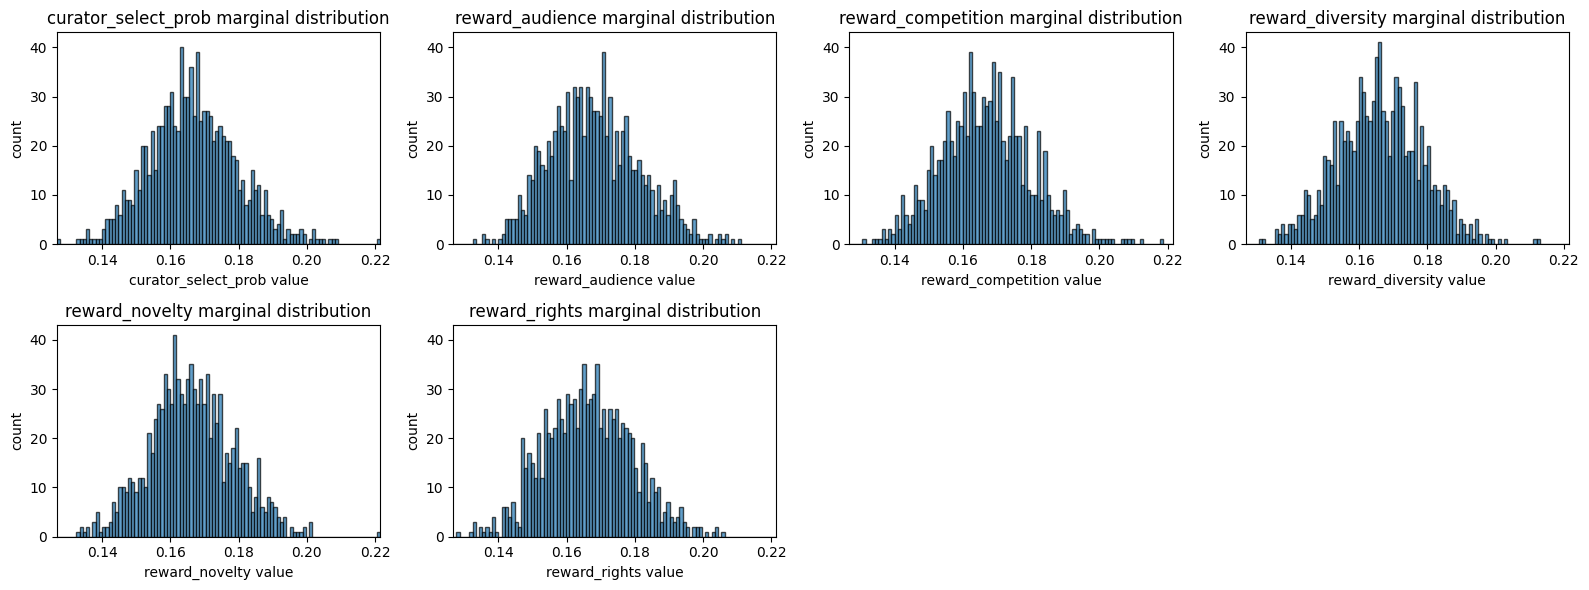

In [44]:
from contextual_thompson import ContextualThompsonSampler, sigmoid
from contextual_ts_testing import *

cts = ContextualThompsonSampler(num_signals=X_hist.shape[1], context_dim=context_features.shape[1], lr = 1e-3, max_grad_norm=0.5, ema_decay=1-1e-3, expl_scale=0.001, h0=1e-1)
fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100)
plt.show()

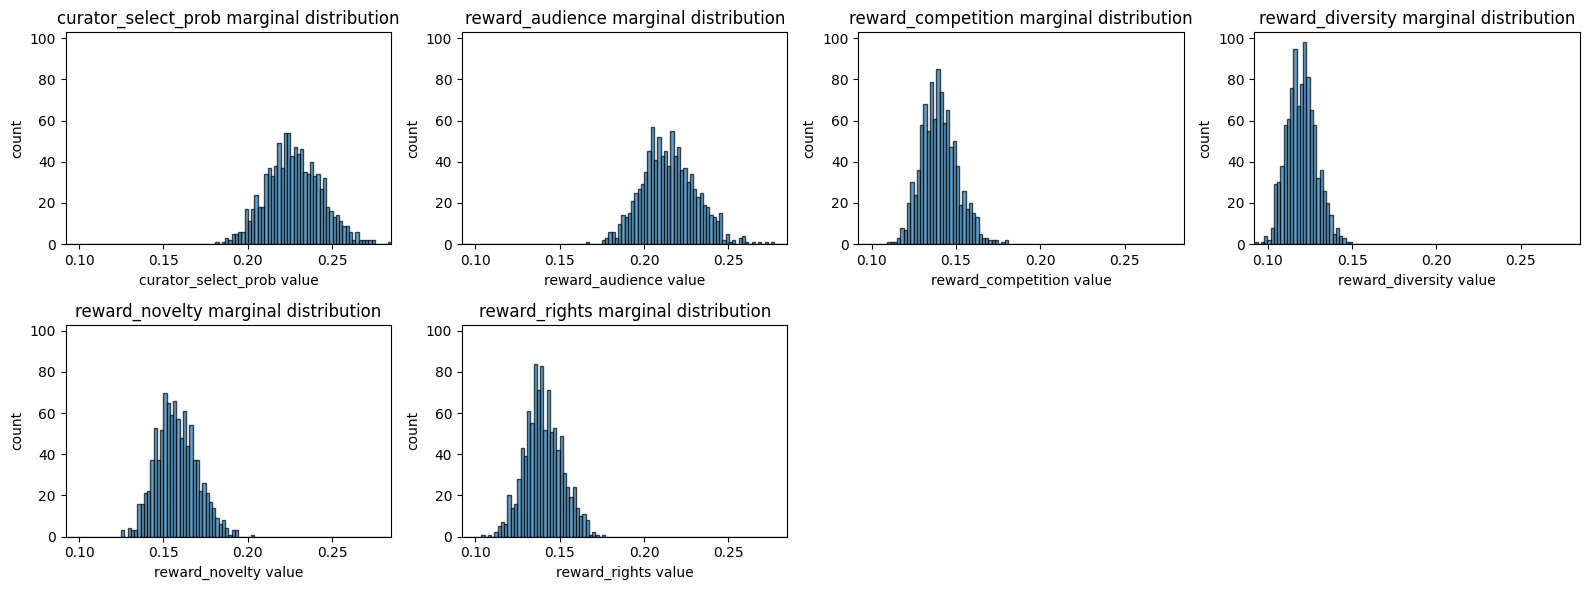

Mean param std: 0.09999999999999999


In [45]:
w_target = np.zeros(X_hist.shape[1]) / X_hist.shape[1]
w_target = [45, 40, 15, 10, 20, 15] 
cts.set_uniform_target_weights(w_target) # Normalizes the sum of weights to be one
fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100)
plt.show()
param_std = np.sqrt(cts.expl_scale / cts.h_U)      # same shape as U
print("Mean param std:", param_std.mean())

cts.warm_start(context_features, X_hist, R_hist, lr=1e-5)
fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100)
plt.show()

In [46]:
n = 100
context_features_subarrays = np.array_split(context_features, n, axis = 0)
X_hist_subarrays = np.array_split(X_hist, n, axis = 0)
R_hist_subarrays = np.array_split(R_hist, n, axis = 0)


In [47]:
i = 0

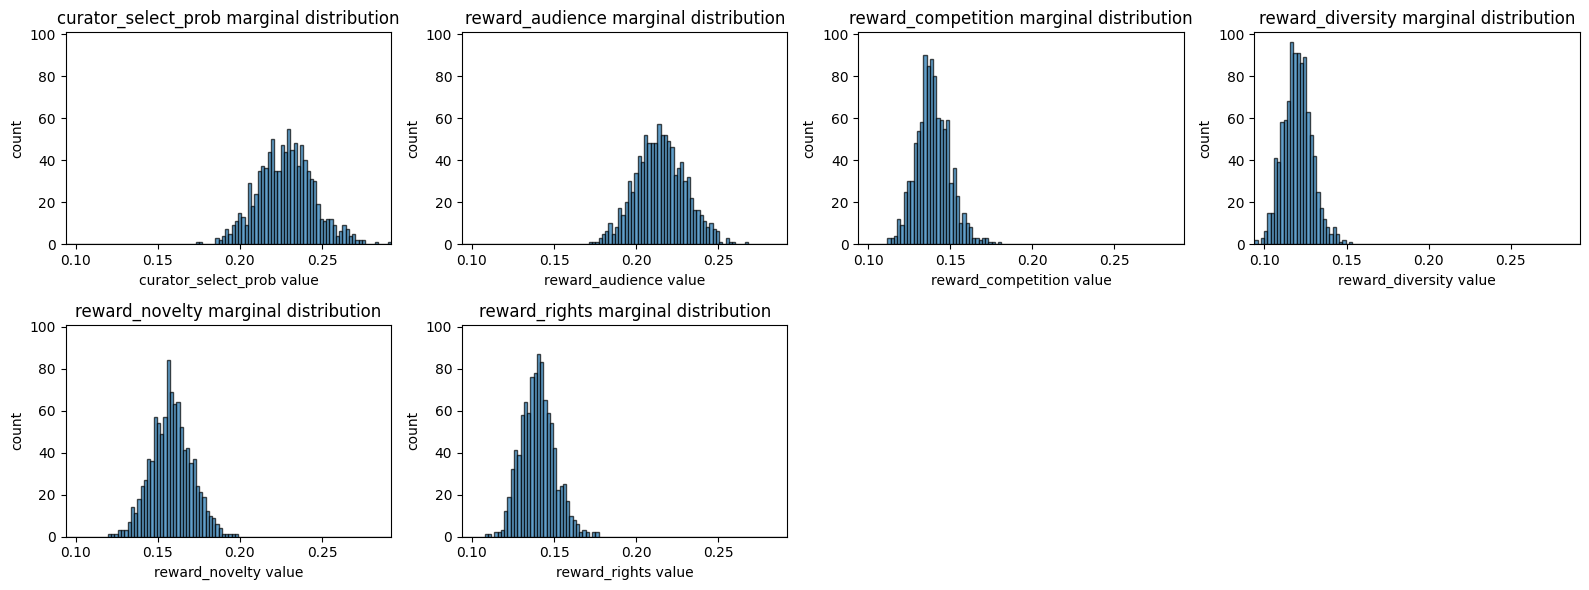

Mean param std: 0.10054147285319924
h_U: 0.09892578700379334, h_b: 0.0993335820699905
Mean param std: 0.10108586870505935
h_U: 0.0978631306335937, h_b: 0.09867376952695776
Mean param std: 0.10163321300713601
h_U: 0.09681188785539187, h_b: 0.09802092878270996
Mean param std: 0.10217840972470453
h_U: 0.09578151931575189, h_b: 0.09738047976633672
Mean param std: 0.10272652862424649
h_U: 0.09476212149955565, h_b: 0.09674672514250669
Mean param std: 0.10327759245947375
h_U: 0.09375356465058982, h_b: 0.09612042342998565
Mean param std: 0.10383161388498424
h_U: 0.09275573927326863, h_b: 0.09550039676914986
Mean param std: 0.10438860298083612
h_U: 0.09176854140849516, h_b: 0.09488666808034131
Mean param std: 0.1049485829434763
h_U: 0.09079184511460085, h_b: 0.09427982049084839
Mean param std: 0.10551156189749263
h_U: 0.08982555227242783, h_b: 0.09367915964440814
Mean param std: 0.10607756184803319
h_U: 0.08886954197398488, h_b: 0.09308475645274124
Mean param std: 0.10664660235671802
h_U: 0.087

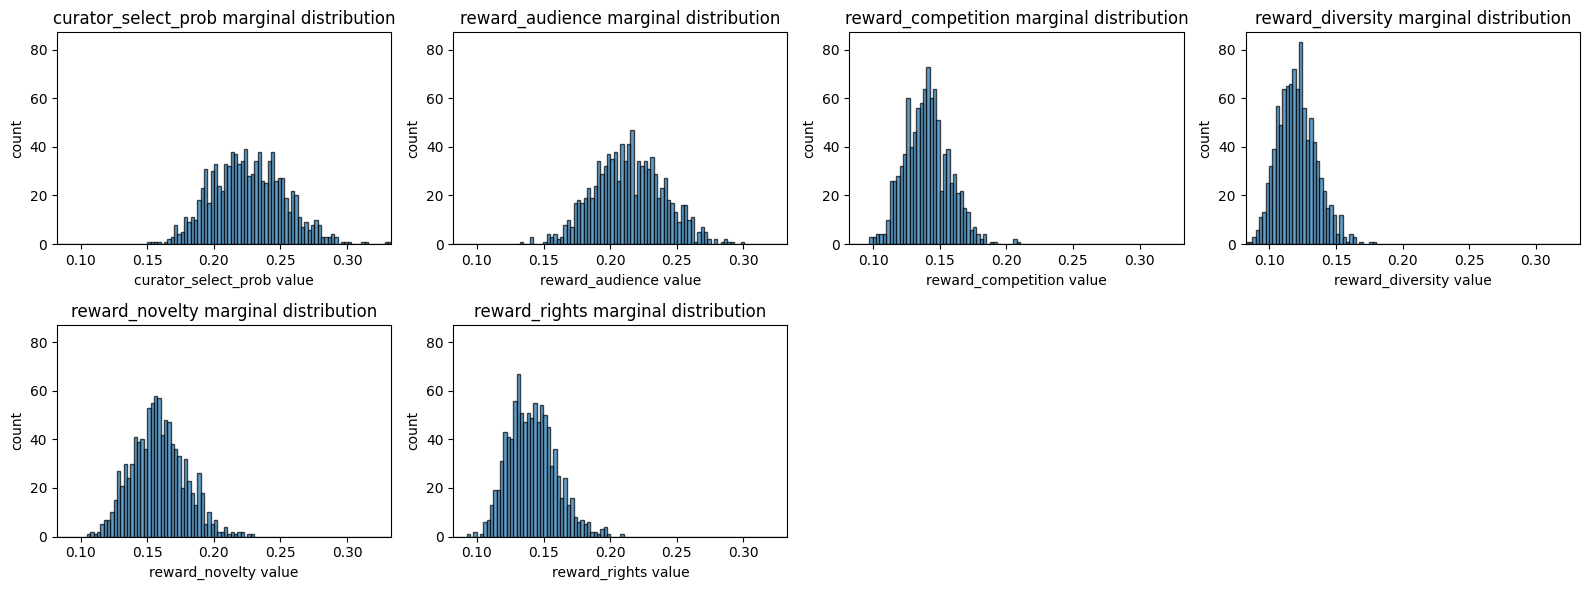

In [48]:
fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100)
plt.show()
for i in range(n):
    cts.warm_start(context_features_subarrays[i], X_hist_subarrays[i], R_hist_subarrays[i], lr=1e-5)
    param_std = np.sqrt(cts.expl_scale / cts.h_U)      # same shape as U
    print("Mean param std:", param_std.mean())
    print(f'h_U: {cts.h_U.mean()}, h_b: {cts.h_b.mean()}')

fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100)
plt.show()

In [49]:
with torch.no_grad():  # no grad for inference
    selection_prob = torch.Tensor.numpy(curator_model(context_tensor, movie_tensor))

In [50]:
print(f'hyperparams: ema_decay = {cts.ema_decay}')

hyperparams: ema_decay = 0.999


## Test recommendations

In [51]:
date = '2025-08-02'
hour = 21
def get_context_features_from_date_hour(date: str, hour: int):
    air_date = utils.date_formatting.to_datetime_format(date)
    context = env.create_context_from_date(date, hour)
    context_f, _ = env.get_context_features(context)
    return context_f, context, air_date

context_f, context, air_date = get_context_features_from_date_hour(date, hour)

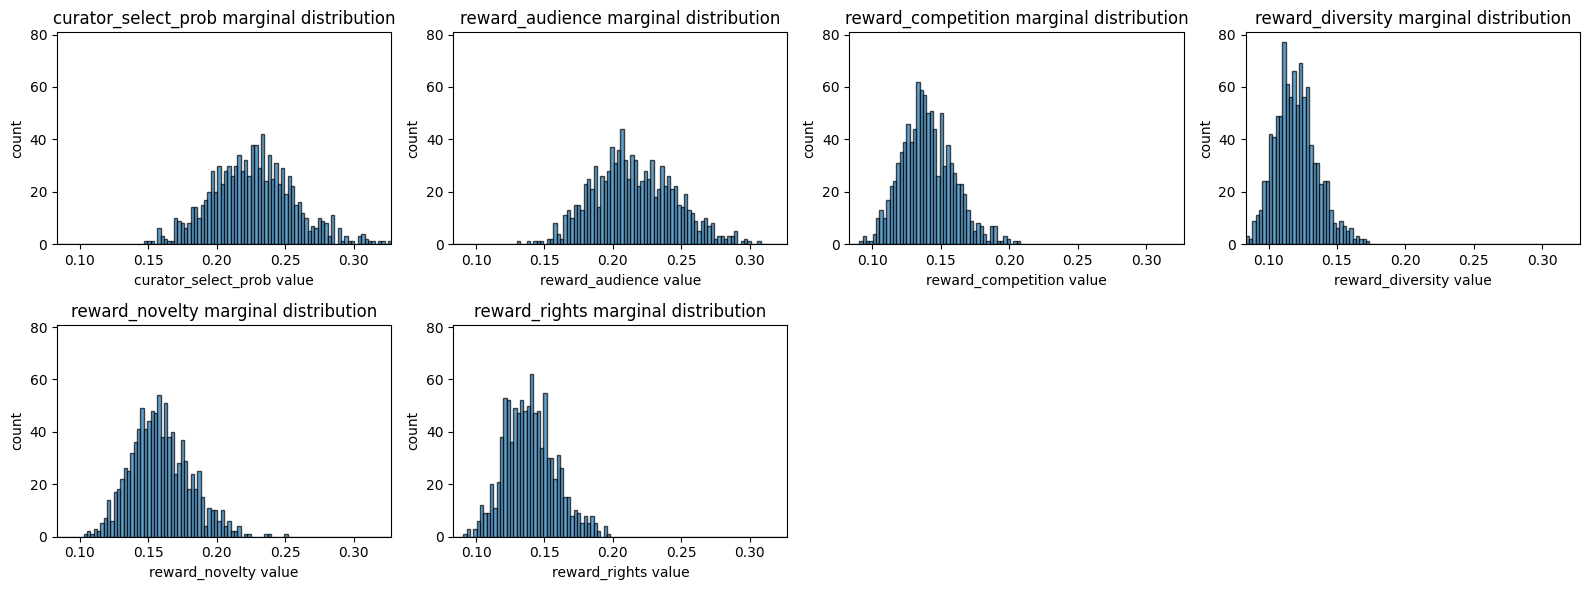

In [52]:
fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100, context_features=context_f)
plt.show()

In [53]:
env.competitor_manager.update_competition_historical_data() # scrape future shwoings and add to historical data
env.get_available_movies(air_date, context)

[datetime.date(2025, 8, 9), datetime.date(2025, 8, 16), datetime.date(2025, 8, 23)]


Weeks for M6: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


In [55]:
env.competitor_manager.competition_scraper.scraped_schedules

{'TF1': {'34': [{'date': '17/08/2025',
    'time': '21.10',
    'title': 'Un petit miracle'},
   {'date': '20/08/2025',
    'time': '21.10',
    'title': 'Les gardiens de la galaxie 2'},
   {'date': '20/08/2025', 'time': '23.45', 'title': 'Thor : Ragnarök'},
   {'date': '21/08/2025',
    'time': '21.10',
    'title': 'Notre tout petit petit mariage'},
   {'date': '21/08/2025', 'time': '22.45', 'title': "Joséphine s'arrondit"}],
  '35': [{'date': '24/08/2025', 'time': '21.10', 'title': 'Spy'},
   {'date': '24/08/2025',
    'time': '23.20',
    'title': 'Les gardiens de la galaxie 2'},
   {'date': '28/08/2025', 'time': '21.10', 'title': 'All inclusive'}],
  '31': [{'date': '27/07/2025', 'time': '21.15', 'title': 'Gran Torino'},
   {'date': '29/07/2025', 'time': '21.10', 'title': 'Taxi 4'},
   {'date': '29/07/2025', 'time': '22.50', 'title': 'Taxi 3'},
   {'date': '30/07/2025', 'time': '21.10', 'title': 'Un plan parfait'}],
  '32': [{'date': '03/08/2025', 'time': '21.10', 'title': 'Une be

In [ ]:
def recommend_n_films(context, air_date, curator_model):
    # movies: list of movie IDs, X_cands: Mxd numpy array
    # Thompson‐Sampling selects one
    print('Getting candidate features...')
    context_f, _ = env.get_context_features(context)
    movies, X_cands = env.get_candidate_features_cts_cur(context, air_date, curator_model=curator_model)
    print('Done')
    top5_idx, top5_scores, w_tilde, _ = cts.score_candidates(context_f, X_cands, K=5)
    recommended = [movies[i] for i in top5_idx]

    for movie, score in zip(recommended, top5_scores):
        print(f"{movie}: score = {score:.3f}")

    return recommended, top5_idx, top5_scores, w_tilde, movies, X_cands

recommended, top5_idx, top5_scores, w_tilde, movies, X_cands  = recommend_n_films(context, air_date, curator_model)


In [ ]:
print(f'hyperparams: ema_decay = {cts.ema_decay}')

In [ ]:
env.movie_catalog.loc[recommended]['processed_title'].to_list()

In [ ]:
env.movie_catalog.loc[recommended]

In [ ]:
def show_top_breakdown(top5_idx, top5_scores, w_tilde, movies, X_cands):
    eps = 1e-9  # threshold to consider "non-zero"
    for i, idx in enumerate(top5_idx):
        movie_id = movies[idx]
        x = X_cands[idx]
        total = top5_scores[i]
        print(f"\n🎬 {movie_id}: {env.movie_catalog.loc[movie_id]['title']}  (total score = {total:.3f}) (p = {sigmoid(total)})")
        print("  Breakdown:")

        # build list of (name, xi, wi, contribution)
        contribs = [
            (name, float(xi), float(wi), float(xi * wi))
            for name, xi, wi in zip(all_feature_names, x, w_tilde)
        ]
        # filter out negligible contributions
        nonzero = [t for t in contribs if abs(t[3]) > eps]
        # sort by absolute impact (change to key=lambda t: -t[3] if you want signed descending)
        nonzero.sort(key=lambda t: t[3], reverse=True)

        for name, xi, wi, contrib in nonzero:
            sign = "+" if contrib >= 0 else "-"
            print(f"    • {name:30s} {xi:6.3f} × {wi:6.3f} = {contrib:7.3f} ({sign})")

show_top_breakdown(top5_idx, top5_scores, w_tilde, movies, X_cands)


In [ ]:
recommended

## Loop

In [ ]:
import copy

cts_copy = copy.deepcopy(cts)

In [ ]:
print(f'h_U: {cts_copy.h_U.mean()}, h_b: {cts_copy.h_b.mean()}')
print(f'hyperparams: ema_decay = {cts_copy.ema_decay}')
fig, axes, samples = marginal_weight_distribution_cts(cts_copy, env, all_feature_names, num_samples=1000, show=False, bins=100)
plt.show()

In [ ]:
from IPython.display import clear_output
chosen_movie = '-1'


while chosen_movie == '-1':
    chosen_movie = input()
    if chosen_movie != '-1':
        chosen_idx = movies.index(chosen_movie)
    else:
        chosen_idx = -1
    
    for idx in top5_idx:
        x_i = X_cands[idx]                    # feature vector for this shown movie

        if idx == chosen_idx:
            r = 1                            # curator chose it
        else:
            r = 0                            # curator did *not* choose it

        cts_copy.update(context_f, x_i, r)                   # Bayesian update: A ← A + x xᵀ; b ← b + r·x
        param_std = np.sqrt(cts_copy.expl_scale / cts_copy.h_U)      # same shape as U
        print("Mean param std:", param_std.mean())
        print(f'h_U: {cts_copy.h_U.mean()}, h_b: {cts_copy.h_b.mean()}')
    fig, axes, samples = marginal_weight_distribution_cts(cts_copy, env, all_feature_names, num_samples=1000, show=False, bins=100)
    plt.show()
    print('Type go when done analyzing')
    status = input()
    if status == '':
        break
    if chosen_movie == '-1':
        available_movies = [movie for  movie in env.available_movies if movie not in recommended]
        env.available_movies= available_movies
        print(len(env.available_movies))
        clear_output(wait=True)
        recommended, top5_idx, top5_scores, w_tilde, movies, X_cands  = recommend_n_films(context, air_date, curator_model)
        show_top_breakdown(top5_idx, top5_scores, w_tilde, movies, X_cands)

chosen_movie = '-1'

In [ ]:
fig, axes, samples = marginal_weight_distribution_cts(cts, env, all_feature_names, num_samples=1000, show=False, bins=100, context_features=context_f)
plt.show()

In [ ]:
env.movie_catalog.loc[recommended]

## Save Thompson Sampling model

In [ ]:
cts_copy.save(Path("models/ts_state.npz"))


In [ ]:
ts = ContextualThompsonSampler.load(Path("models/ts_state.npz"))